<a href="https://colab.research.google.com/github/VitalyGladyshev/NeuroN/blob/master/HW_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ_05

## Задание 1

Попробуйте обучить нейронную сеть LSTM на любом другом датасете. Опишите в комментарии к уроку - какой результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku
from tensorflow.keras.callbacks import EarlyStopping 

from google.colab import files

from typing import List, Tuple

In [2]:
def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [40]:
# files.upload()

In [4]:
!ls

sample_data  shakespear.txt


## Базовый вариант

In [15]:
tokenizer = Tokenizer(num_words=1000)
data = open('shakespear.txt').read()
corpus = data.lower().split("\n")

In [16]:
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [17]:
callback = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model = Sequential()
model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
#model.add(Bidirectional(LSTM(50, return_sequences = True)))
#model.add(Dropout(0.2))
model.add(LSTM(10))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 10)            35430     
_________________________________________________________________
lstm (LSTM)                  (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 1771)              19481     
_________________________________________________________________
dense_1 (Dense)              (None, 3543)              6278196   
Total params: 6,333,947
Trainable params: 6,333,947
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(predictors, label, epochs=100, validation_split=0.2, callbacks=[callback],verbose=1)

Epoch 1/100
331/331 [==============================] - 23s 69ms/step - loss: 6.2136 - accuracy: 0.0309 - val_loss: 5.8145 - val_accuracy: 0.0310
Epoch 2/100
331/331 [==============================] - 22s 67ms/step - loss: 5.7499 - accuracy: 0.0334 - val_loss: 5.7827 - val_accuracy: 0.0310
Epoch 3/100
331/331 [==============================] - 22s 67ms/step - loss: 5.7150 - accuracy: 0.0346 - val_loss: 5.7575 - val_accuracy: 0.0310
Epoch 4/100
331/331 [==============================] - 22s 67ms/step - loss: 5.6752 - accuracy: 0.0367 - val_loss: 5.7422 - val_accuracy: 0.0397
Epoch 5/100
331/331 [==============================] - 22s 67ms/step - loss: 5.6317 - accuracy: 0.0412 - val_loss: 5.7222 - val_accuracy: 0.0427
Epoch 6/100
331/331 [==============================] - 22s 67ms/step - loss: 5.5892 - accuracy: 0.0416 - val_loss: 5.6865 - val_accuracy: 0.0427
Epoch 7/100
331/331 [==============================] - 22s 67ms/step - loss: 5.5416 - accuracy: 0.0438 - val_loss: 5.6725 - val_ac

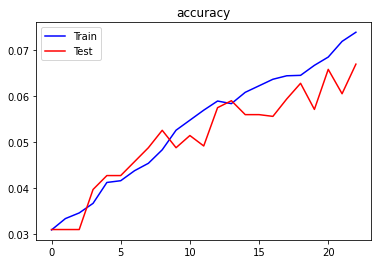

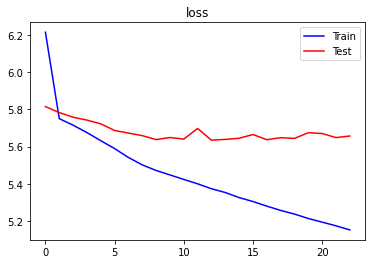

In [ ]:
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

## Варианты топологий

In [35]:
def net_gen(lay_name='GRU', func_act="tanh", units=10):
    model = Sequential()

    model.add(Embedding(total_words, units, input_length=max_sequence_len-1))
    #model.add(Bidirectional(LSTM(50, return_sequences = True)))
    #model.add(Dropout(0.2))
    model.add(eval(lay_name)(units, activation=func_act))    # model.add(lay_name(units, activation=func_act))
    model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(total_words, activation='softmax'))
 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [36]:
def net_iter(model, ep=10, batch_size=512):
    history = model.fit(predictors, 
                        label, 
                        epochs=ep, 
                        validation_split=0.2,
                        verbose=1)
    return history.history

In [37]:
summary_data = pd.DataFrame(data=[[0, 0, 0, 0, 0, 0, 0, 0]], 
                            columns=['layers', 'func_act', 'unit_number', 'mean_train_accuracy', 'mean_val_accuracy', 'variance', 'l_b', 'r_b'])
cnt = 0
lay_name = ['SimpleRNN', 'LSTM', 'GRU']   # [SimpleRNN, LSTM, GRU] 
f_act = ['tanh', 'sigmoid']    # 'relu', 
unit_number = [10, 20]    # , 50
epochs = 5

for l_n in lay_name:
    for f_a in f_act:
        for u_n in unit_number:
            err_accuracy = []
            err_val_accuracy = []
            print(f"Модель: слой {l_n}, функция активации {f_a}, число блоков {u_n}, эпох {epochs}\n")
            model = net_gen(lay_name=l_n, func_act=f_a, units=u_n)
            model.summary()
            for i in range(3):  # range(5):
                print(f"\tИтерация: {i+1}")
                hist = net_iter(model, ep=epochs)
                err_accuracy.append(hist['accuracy'][-1])
                err_val_accuracy.append(hist['val_accuracy'][-1])

            vr = np.var(err_val_accuracy)
            l_b, r_b = calculate_confidence_interval(err_val_accuracy)
            mean_err_accuracy, mean_err_val_accuracy = np.mean(err_accuracy), np.mean(err_val_accuracy)
            print(f"Ошибки на train. Средняя: {mean_err_accuracy} список: {err_accuracy}")
            print(f"Ошибки на valid. Средняя: {mean_err_val_accuracy} список: {err_val_accuracy}")
            print(f"Дисперсия ошибки на valid: {vr}")
            print(f"Доверительный интервал: {l_b} - {r_b}\n\n")
            summary_data.loc[cnt, ['layers', 'func_act', 'unit_number', 'mean_train_accuracy', 
                                   'mean_val_accuracy', 'variance', 'l_b', 'r_b']] = [l_n, f_a, u_n, 
                                            np.mean(err_accuracy), np.mean(err_val_accuracy), vr, l_b, r_b]
            cnt += 1

Модель: слой SimpleRNN, функция активации tanh, число блоков 10, эпох 5

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 14, 10)            35430     
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_12 (Dense)             (None, 1771)              19481     
_________________________________________________________________
dense_13 (Dense)             (None, 3543)              6278196   
Total params: 6,333,317
Trainable params: 6,333,317
Non-trainable params: 0
_________________________________________________________________
	Итерация: 1
Epoch 1/5
331/331 [==============================] - 28s 84ms/step - loss: 6.1466 - accuracy: 0.0330 - val_loss: 5.7802 - val_accuracy: 0.0310
Epoch 2/5
33

In [38]:
summary_data

,layers,func_act,unit_number,mean_train_accuracy,mean_val_accuracy,variance,l_b,r_b
0,SimpleRNN,tanh,10.0,0.064794,0.052320,0.000072,0.043476,0.062878
1,SimpleRNN,tanh,20.0,0.073811,0.056354,0.000063,0.046104,0.063710
2,SimpleRNN,sigmoid,10.0,0.047894,0.048159,0.000022,0.043306,0.054085
3,SimpleRNN,sigmoid,20.0,0.049187,0.048664,0.000057,0.041452,0.058340
4,LSTM,tanh,10.0,0.052812,0.052824,0.000104,0.040129,0.063483
5,LSTM,tanh,20.0,0.057479,0.055976,0.000194,0.040450,0.072787
6,LSTM,sigmoid,10.0,0.046853,0.046899,0.000012,0.043930,0.051475
7,LSTM,sigmoid,20.0,0.047358,0.048033,0.000020,0.043646,0.053707
8,GRU,tanh,10.0,0.057983,0.056102,0.000111,0.044421,0.068854
9,GRU,tanh,20.0,0.072046,0.064044,0.000057,0.054974,0.072579


In [39]:
summary_data.sort_values('mean_val_accuracy', ascending=False)

,layers,func_act,unit_number,mean_train_accuracy,mean_val_accuracy,variance,l_b,r_b
9,GRU,tanh,20.0,0.072046,0.064044,0.000057,0.054974,0.072579
1,SimpleRNN,tanh,20.0,0.073811,0.056354,0.000063,0.046104,0.063710
8,GRU,tanh,10.0,0.057983,0.056102,0.000111,0.044421,0.068854
5,LSTM,tanh,20.0,0.057479,0.055976,0.000194,0.040450,0.072787
4,LSTM,tanh,10.0,0.052812,0.052824,0.000104,0.040129,0.063483
0,SimpleRNN,tanh,10.0,0.064794,0.052320,0.000072,0.043476,0.062878
3,SimpleRNN,sigmoid,20.0,0.049187,0.048664,0.000057,0.041452,0.058340
11,GRU,sigmoid,20.0,0.049060,0.048285,0.000083,0.037954,0.059153
2,SimpleRNN,sigmoid,10.0,0.047894,0.048159,0.000022,0.043306,0.054085
7,LSTM,sigmoid,20.0,0.047358,0.048033,0.000020,0.043646,0.053707


# Выводы
Можно сделть вывод, что применение функции активации tanh, а также применение более длинных цепочек способствует повышению значения метрики на valid выборках. Однако, большая вычислительная сложность эксперимента привела к критическому сокращению количества эпох и итераций. Для получения более репрезентативных результатов необходимо проводить более объёмное исследование

## Задание 2

Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM

Реализация (как есть из книги Э.Траска "GrokkingDeepLearning")

Рассматривется пример создния фреймворка с ключевыми слоями для демонстрации автоматизации обратного распрострнения. Данный фреймворк включает в себя класс, реализующий рекурентную ячейку и её развитие - LSTM слой.

In [ ]:
class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None

        if(id is None):
            self.id = np.random.randint(0,1000000000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    return
                    print(self.id)
                    print(self.creation_op)
                    print(len(self.creators))
                    for c in self.creators:
                        print(c.creation_op)
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def softmax(self):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        return softmax_output
    
    def cross_entropy(self, target_indices):

        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)
        
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  

class Layer(object):
    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters

    
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0


class Linear(Layer):

    def __init__(self, n_inputs, n_outputs, bias=True):
        super().__init__()
        
        self.use_bias = bias
        
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        if(self.use_bias):
            self.bias = Tensor(np.zeros(n_outputs), autograd=True)
        
        self.parameters.append(self.weight)
        
        if(self.use_bias):        
            self.parameters.append(self.bias)

    def forward(self, input):
        if(self.use_bias):
            return input.mm(self.weight)+self.bias.expand(0,len(input.data))
        return input.mm(self.weight)


class Sequential(Layer):
    
    def __init__(self, layers=list()):
        super().__init__()
        
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params


class Embedding(Layer):
    
    def __init__(self, vocab_size, dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.dim = dim
        
        # this random initialiation style is just a convention from word2vec
        self.weight = Tensor((np.random.rand(vocab_size, dim) - 0.5) / dim, autograd=True)
        
        self.parameters.append(self.weight)
    
    def forward(self, input):
        return self.weight.index_select(input)


class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()


class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()
    

class CrossEntropyLoss(object):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        return input.cross_entropy(target)

    
class RNNCell(Layer):
    
    def __init__(self, n_inputs, n_hidden, n_output, activation='sigmoid'):
        super().__init__()

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        if(activation == 'sigmoid'):
            self.activation = Sigmoid()
        elif(activation == 'tanh'):
            self.activation == Tanh()
        else:
            raise Exception("Non-linearity not found")

        self.w_ih = Linear(n_inputs, n_hidden)
        self.w_hh = Linear(n_hidden, n_hidden)
        self.w_ho = Linear(n_hidden, n_output)
        
        self.parameters += self.w_ih.get_parameters()
        self.parameters += self.w_hh.get_parameters()
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        from_prev_hidden = self.w_hh.forward(hidden)
        combined = self.w_ih.forward(input) + from_prev_hidden
        new_hidden = self.activation.forward(combined)
        output = self.w_ho.forward(new_hidden)
        return output, new_hidden
    
    def init_hidden(self, batch_size=1):
        return Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
    
class LSTMCell(Layer):
    
    def __init__(self, n_inputs, n_hidden, n_output):
        super().__init__()

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output

        self.xf = Linear(n_inputs, n_hidden)
        self.xi = Linear(n_inputs, n_hidden)
        self.xo = Linear(n_inputs, n_hidden)        
        self.xc = Linear(n_inputs, n_hidden)        
        
        self.hf = Linear(n_hidden, n_hidden, bias=False)
        self.hi = Linear(n_hidden, n_hidden, bias=False)
        self.ho = Linear(n_hidden, n_hidden, bias=False)
        self.hc = Linear(n_hidden, n_hidden, bias=False)        
        
        self.w_ho = Linear(n_hidden, n_output, bias=False)
        
        self.parameters += self.xf.get_parameters()
        self.parameters += self.xi.get_parameters()
        self.parameters += self.xo.get_parameters()
        self.parameters += self.xc.get_parameters()

        self.parameters += self.hf.get_parameters()
        self.parameters += self.hi.get_parameters()        
        self.parameters += self.ho.get_parameters()        
        self.parameters += self.hc.get_parameters()                
        
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        
        prev_hidden = hidden[0]        
        prev_cell = hidden[1]
        
        f = (self.xf.forward(input) + self.hf.forward(prev_hidden)).sigmoid()
        i = (self.xi.forward(input) + self.hi.forward(prev_hidden)).sigmoid()
        o = (self.xo.forward(input) + self.ho.forward(prev_hidden)).sigmoid()        
        g = (self.xc.forward(input) + self.hc.forward(prev_hidden)).tanh()        
        
        c = (f * prev_cell) + (i * g)
        h = o * c.tanh()
        
        output = self.w_ho.forward(h)
        return output, (h, c)
    
    def init_hidden(self, batch_size=1):
        init_hidden = Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
        init_cell = Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
        init_hidden.data[:,0] += 1
        init_cell.data[:,0] += 1
        return (init_hidden, init_cell)

Ячейка LSTM имеет два вектора со скрытым состоянием: h (от англ. hidden — скрытый) и cell.

    c = (f * prev_cell) + (i * g)
    h = o * c.tanh()

В векторе cell каждое новое значение является суммой предыдущего значения и приращения и, взвешенных весами f и i. Здесь f — это «забывающий» («forget») вентиль (фильтр). Если этот вес получит значение 0, новая ячейка «забудет» то, что видела прежде. Если i получит значение 1, приращение и будет полностью добавлено в новую ячейку. Переменная о — это выходной вентиль (фильтр), который определяет, какая доля состояния ячейки попадет в прогноз. Например, если все значения в о равны нулю, тогда строка self.w_ho.forward(h) вернет прогноз, полностью игнорируя состояние ячейки.

Три вентиля — f, i, о — и вектор приращений ячейки и; их можно представить как механизмы управления забыванием (forget), вводом (input), выводом (output) и изменением (update) соответственно. Они действуют вместе и гарантируют, что для корректировки информации, хранящейся в с, не потребуется применять матричное умножение или нелинейную функцию активации. Иначе говоря, избавляют от необходимости вызывать nonlinearity(c) или с. dot (weights).

Такой подход позволяет модели LSTM сохранять информацию на протяжении
временной последовательности, не беспокоясь о затухании или взрывном росте
градиентов. Каждый шаг заключается в копировании (если f имеет ненулевое
значение) и прибавлении приращения (если i имеет ненулевое значение).
Скрытое значение h — это замаскированная версия ячейки, используемая для
получения прогноза.

Все три вентиля формируются совершенно одинаково. Они имеют свои весовые матрицы, но каждый зависит от входных значений и скрытого состояния, пропущенных через функцию sigmoid. Именно эта нелинейная функция sigmoid делает их полезными в качестве вентилей, преобразуя в диапазон от 0 до 1:

    f = (self,xf.forward(input) + self.hf.forward(prev_hidden)).sigmoid()
    i = (self.xi.forward(input) + self.hi.forward(prev_hidden)).sigmoid()
    о = (self.xo.forward(input) + self.ho.forward(prev_hidden)).sigmoid()

Вектор h все еще подвержен эффекту затухания и взрывного роста градиентов, потому что фактически используется так же, как в простой рекуррентной нейронной сети. Во-первых, поскольку вектор h всегда создается из комбинации векторов, которые сжимаются с помощью tanh и sigmoid, эффект взрывного роста градиентов на самом деле отсутствует — проявляется только эффект затухания. Но в итоге в этом нет ничего страшного, потому что h зависит от ячейки с, которая может переносить информацию на дальние расстояния: ту информацию, которую затухающие градиенты не способны переносить. То есть вся перспективная информация транспортируется с помощью с, a h — это всего лишь локальная интерпретация с, удобная для получения прогноза на выходе и активации вентилей на следующем шаге. Проще говоря, способность с переносить информацию на большие расстояния нивелирует неспособность h к тому же самому.

In [ ]:
import sys,random,math
from collections import Counter
import numpy as np
import sys

np.random.seed(0)

# dataset from http://karpathy.github.io/2015/05/21/rnn-effectiveness/
f = open('shakespear.txt','r')
raw = f.read()
f.close()

vocab = list(set(raw))
word2index = {}
for i,word in enumerate(vocab):
    word2index[word]=i
indices = np.array(list(map(lambda x:word2index[x], raw)))

embed = Embedding(vocab_size=len(vocab),dim=512)
model = LSTMCell(n_inputs=512, n_hidden=512, n_output=len(vocab))
model.w_ho.weight.data *= 0

criterion = CrossEntropyLoss()
optim = SGD(parameters=model.get_parameters() + embed.get_parameters(), alpha=0.05)

batch_size = 16
bptt = 25
n_batches = int((indices.shape[0] / (batch_size)))

trimmed_indices = indices[:n_batches*batch_size]
batched_indices = trimmed_indices.reshape(batch_size, n_batches).transpose()

input_batched_indices = batched_indices[0:-1]
target_batched_indices = batched_indices[1:]

n_bptt = int(((n_batches-1) / bptt))
input_batches = input_batched_indices[:n_bptt*bptt].reshape(n_bptt,bptt,batch_size)
target_batches = target_batched_indices[:n_bptt*bptt].reshape(n_bptt, bptt, batch_size)

In [ ]:
raw[0:20]

'That, poor contempt,'

In [ ]:
indices[0:20]

array([18,  9, 16, 54, 41, 39, 14, 60, 60, 11, 39, 56, 60,  3, 54, 45, 47,
       14, 54, 41])

In [ ]:
batched_indices[0:5]

array([[18,  5, 45, 21, 39, 45,  7, 36, 27, 33, 18, 42, 36, 48, 36, 54],
       [ 9, 26, 39, 60, 43, 39, 60, 36, 54, 39, 55, 39, 36, 39, 39,  9],
       [16, 18, 43, 54, 45, 54, 11, 39, 39,  9, 29, 45, 39, 54, 21, 23],
       [54, 28, 28, 26, 36,  9, 54, 16, 28, 16, 44,  4,  9,  9, 45,  5],
       [41, 50, 36, 50, 36, 28, 45, 36, 54,  4,  5, 45, 28, 45, 22,  5]])

In [ ]:
input_batches[0][0:5]

array([[18,  5, 45, 21, 39, 45,  7, 36, 27, 33, 18, 42, 36, 48, 36, 54],
       [ 9, 26, 39, 60, 43, 39, 60, 36, 54, 39, 55, 39, 36, 39, 39,  9],
       [16, 18, 43, 54, 45, 54, 11, 39, 39,  9, 29, 45, 39, 54, 21, 23],
       [54, 28, 28, 26, 36,  9, 54, 16, 28, 16, 44,  4,  9,  9, 45,  5],
       [41, 50, 36, 50, 36, 28, 45, 36, 54,  4,  5, 45, 28, 45, 22,  5]])

In [ ]:
target_batches[0][0:5]

array([[ 9, 26, 39, 60, 43, 39, 60, 36, 54, 39, 55, 39, 36, 39, 39,  9],
       [16, 18, 43, 54, 45, 54, 11, 39, 39,  9, 29, 45, 39, 54, 21, 23],
       [54, 28, 28, 26, 36,  9, 54, 16, 28, 16, 44,  4,  9,  9, 45,  5],
       [41, 50, 36, 50, 36, 28, 45, 36, 54,  4,  5, 45, 28, 45, 22,  5],
       [39, 39, 36, 39, 41,  3, 11, 36, 39, 45, 53, 11, 47, 47, 39, 35]])

In [ ]:
def generate_sample(n=30, init_char=' '):
    s = ""
    hidden = model.init_hidden(batch_size=1)
    input = Tensor(np.array([word2index[init_char]]))
    for i in range(n):
        rnn_input = embed.forward(input)
        output, hidden = model.forward(input=rnn_input, hidden=hidden)
#         output.data *= 25
#         temp_dist = output.softmax()
#         temp_dist /= temp_dist.sum()

#         m = (temp_dist > np.random.rand()).argmax()
        m = output.data.argmax()
        c = vocab[m]
        input = Tensor(np.array([m]))
        s += c
    return s

In [ ]:
min_loss

1000

In [ ]:
def train(iterations=400):
    min_loss = 1000
    for iter in range(iterations):
        total_loss = 0
        n_loss = 0

        hidden = model.init_hidden(batch_size=batch_size)
        batches_to_train = len(input_batches)
    #     batches_to_train = 32
        for batch_i in range(batches_to_train):

            hidden = (Tensor(hidden[0].data, autograd=True), Tensor(hidden[1].data, autograd=True))

            losses = list()
            for t in range(bptt):
                input = Tensor(input_batches[batch_i][t], autograd=True)
                rnn_input = embed.forward(input=input)
                output, hidden = model.forward(input=rnn_input, hidden=hidden)

                target = Tensor(target_batches[batch_i][t], autograd=True)    
                batch_loss = criterion.forward(output, target)

                if(t == 0):
                    losses.append(batch_loss)
                else:
                    losses.append(batch_loss + losses[-1])

            loss = losses[-1]

            loss.backward()
            optim.step()
            total_loss += loss.data / bptt

            epoch_loss = np.exp(total_loss / (batch_i+1))
            if(epoch_loss < min_loss):
                min_loss = epoch_loss
                print()

            log = "\r Iter:" + str(iter)
            log += " - Alpha:" + str(optim.alpha)[0:5]
            log += " - Batch "+str(batch_i+1)+"/"+str(len(input_batches))
            log += " - Min Loss:" + str(min_loss)[0:5]
            log += " - Loss:" + str(epoch_loss)
            if(batch_i == 0):
                log += " - " + generate_sample(n=70, init_char='T').replace("\n"," ")
            if(batch_i % 1 == 0):
                sys.stdout.write(log)
        optim.alpha *= 0.99

In [ ]:
train(50)


 Iter:0 - Alpha:0.05 - Batch 2/249 - Min Loss:61.43 - Loss:61.50395764660655
 Iter:0 - Alpha:0.05 - Batch 3/249 - Min Loss:61.37 - Loss:61.3736297066837
 Iter:0 - Alpha:0.05 - Batch 4/249 - Min Loss:61.01 - Loss:61.01063938517639
 Iter:0 - Alpha:0.05 - Batch 5/249 - Min Loss:60.26 - Loss:60.269906839785314
 Iter:0 - Alpha:0.05 - Batch 6/249 - Min Loss:58.84 - Loss:58.84148621314299
 Iter:0 - Alpha:0.05 - Batch 7/249 - Min Loss:56.63 - Loss:56.63600933131954
 Iter:0 - Alpha:0.05 - Batch 8/249 - Min Loss:52.68 - Loss:52.68878864926658
 Iter:0 - Alpha:0.05 - Batch 9/249 - Min Loss:48.72 - Loss:48.72161564909471
 Iter:0 - Alpha:0.05 - Batch 10/249 - Min Loss:47.19 - Loss:47.19780782601813
 Iter:0 - Alpha:0.05 - Batch 11/249 - Min Loss:45.42 - Loss:45.424298950589794
 Iter:0 - Alpha:0.05 - Batch 12/249 - Min Loss:44.09 - Loss:44.092127806603465
 Iter:0 - Alpha:0.05 - Batch 13/249 - Min Loss:42.96 - Loss:42.964972808747774
 Iter:0 - Alpha:0.05 - Batch 14/249 - Min Loss:42.45 - Loss:42.45214

KeyboardInterrupt: ignored

In [ ]:
print(generate_sample(n=500, init_char='\n'))

I avo to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to


## Задание 3

Предложите свои варианты решения проблемы исчезающего градиента в RNN

Deep Residual Learning (ResNets)

Когда более глубокая сеть начинает сворачиваться, возникает проблема: с увеличением глубины сети точность сначала увеличивается, а затем быстро ухудшается. Снижение точности обучения показывает, что не все сети легко оптимизировать.


Соединения быстрого доступа (shortcut connections) пропускают один или несколько слоев и выполняют сопоставление идентификаторов. Их выходы добавляются к выходам stacked layers. Используя ResNet, можно решить множество проблем, таких как:

1. ResNet относительно легко оптимизировать: «простые» сети (которые просто складывают слои) показывают большую ошибку обучения, когда глубина увеличивается.
2. ResNet позволяет относительно легко увеличить точность благодаря увеличению глубины, чего с другими сетями добиться сложнее.

